# Gaussian Process with CGCNN Mean (GWCM)
Using a trained CGCNN as prior mean for a GP with Matern kernel.

# Initialize and Train CGCNN

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch
%env CUDA_VISIBLE_DEVICES=1


if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

env: CUDA_VISIBLE_DEVICES=1
Using GPU


Load all of our preprocessed and split data from our cache

In [2]:
import pickle


# Label to use for this model in the plots
model_name = 'GP-with-CGCNN-mean'

with open('../../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)
    

docs_train, docs_val, docs_test = splits['docs_train'], splits['docs_val'], splits['docs_test']
sdts_train, sdts_val, sdts_test = splits['sdts_train'], splits['sdts_val'], splits['sdts_test']
targets_train, targets_val, targets_test = splits['targets_train'], splits['targets_val'], splits['targets_test']

# Where we put the intermediate results for this notebook
prefix = 'gasdb_pooled/'

##### Initialize the CGCNN `net` class

In [3]:
from torch.optim import Adam
# import skorch.callbacks.base
from skorch import callbacks  # needs skorch >= 0.4  
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Callback to checkpoint parameters every time there is a new best for validation loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix=prefix+'valid_best_')

# Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params(prefix+'valid_best_params.pt')
load_best_valid_loss = train_end_load_best_valid_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_valid_loss, LR_schedule]
)
# Initialize CGCNN
net.initialize()

# Note: to re-train:
# net.fit(sdts_train, targets_train)

# Note: to restart training in case first round was cut off
# net.partial_fit(sdts_train, targets_train)

# Load the pre-trained model
net.load_params(f_history=prefix+'valid_best_history.json',
                f_optimizer=prefix+'valid_best_optimizer.pt', 
                f_params=prefix+'valid_best_params.pt')

# Initialize and Train GP with CGCNN Mean

In [4]:
# Imports

%matplotlib inline
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
from scipy import stats
from tqdm import tqdm_notebook

In [5]:
# Get CGCNN predictions on sdts_val, and sdts_train
targets_pred_train = net.predict(sdts_train).reshape(-1)
targets_pred_val = net.predict(sdts_val).reshape(-1)
targets_pred_test = net.predict(sdts_test).reshape(-1)

In [6]:
# Load fingerprints data
fingerprints_train_raw = splits['fingerprints_train']
fingerprints_val_raw = splits['fingerprints_val']
fingerprints_test_raw = splits['fingerprints_test']

# Define all the adsorbates
adsorbates = list({doc['adsorbate'] for doc in docs_val})
adsorbates.sort()

In [7]:
# Scale the fingerprints
scaler = StandardScaler()
fingerprints_train = scaler.fit_transform(fingerprints_train_raw)
fingerprints_val = scaler.transform(fingerprints_val_raw)
fingerprints_test = scaler.transform(fingerprints_test_raw)

# Make torch.Tensor version of data for GPyTorch
fingerprints_train = torch.Tensor(fingerprints_train).contiguous()
fingerprints_val = torch.Tensor(fingerprints_val)
fingerprints_test = torch.Tensor(fingerprints_test)
targets_train_gp = torch.Tensor(targets_train.reshape(-1))
targets_val_gp = torch.Tensor(targets_val.reshape(-1))
targets_test_gp = torch.Tensor(targets_test.reshape(-1))

# Transform targets for GP with nonzero mean
targets_train_gp = targets_train_gp - torch.Tensor(targets_pred_train)
targets_val_gp = targets_val_gp - torch.Tensor(targets_pred_val)
targets_test_gp = targets_test_gp - torch.Tensor(targets_pred_test)

In [8]:
import gpytorch


# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

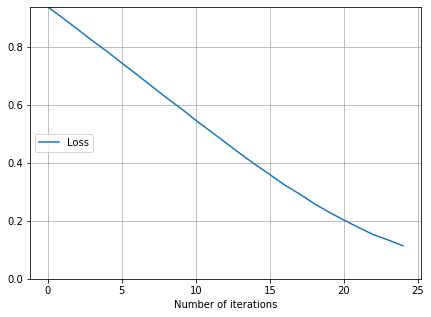

CPU times: user 21min 36s, sys: 13min 57s, total: 35min 33s
Wall time: 35min 33s


In [9]:
# Training the GP

%matplotlib inline
from collections import defaultdict
from matplotlib import pyplot as plt
from IPython.display import clear_output


# Initialize the model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(fingerprints_train, targets_train_gp, likelihood)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Function to make dynamic learning curve
def live_plot(data_dict, figsize=(7, 5), title=''):
    ''' Credit to Ziofil on StackOverflow '''
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label, data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Number of iterations')
    plt.legend(loc='center left')  # the plot evolves to the right
    ax = plt.gca()
    ax.set_ylim(0, max(max(data) for data in data_dict.values()))
    plt.show()

def train(training_iterations=25):
    # Train the model
    learning_curve_data = defaultdict(list)
    for i in range(training_iterations):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(fingerprints_train)
        # Calc loss and backprop derivatives
        loss = -mll(output, targets_train_gp)
        loss.backward()
        # Update the learning curve
        learning_curve_data['Loss'].append(loss.item())
        live_plot(learning_curve_data)
        optimizer.step()

%time train(25)

In [10]:
# Save trained GP model

torch.save(model.state_dict(), 'model_state_25iter.pth')

In [ ]:
# To load saved model
    
# Instantiate GP
# likelihood = gpytorch.likelihoods.GaussianLikelihood().to(output_device)
# model = ExactGPModel(input_train, targets_train, likelihood, n_devices).to(output_device)

# Load the state
# state_dict = torch.load('model_state_25iter.pth')
# model.load_state_dict(state_dict)

# Assess Performance: GP with CGCNN Mean
## Validation
We used the results in this section to tune hyperparameters

##### Transformed Output Space

In [11]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make the predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    %time preds = model(fingerprints_val)

CPU times: user 1min 33s, sys: 17.7 s, total: 1min 50s
Wall time: 1min 50s


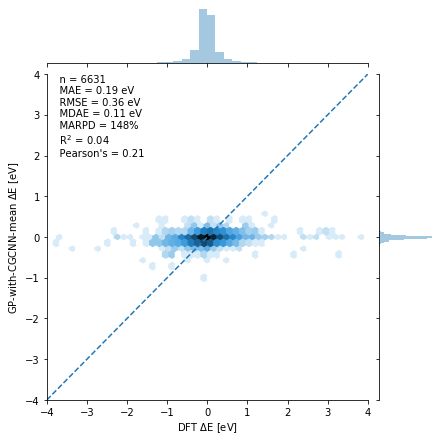

In [12]:
# Plotting results (transformed output space)

# Parse the predictions
targets_pred_gp = preds.mean
residuals = (targets_pred_gp - targets_val_gp).detach().numpy()

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val_gp.reshape(-1),
                     targets_pred_gp.reshape(-1),
                     kind='hex',
                     bins='log',
                     extent=lims*2)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val_gp, targets_pred_gp)
rmse = np.sqrt(mean_squared_error(targets_val_gp, targets_pred_gp))
mdae = median_absolute_error(targets_val_gp, targets_pred_gp)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred_gp.detach().numpy()) + np.abs(targets_val_gp.detach().numpy().reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_val_gp, targets_pred_gp)
corr = np.corrcoef(targets_val_gp.reshape(-1), targets_pred_gp)[0, 1]

# Report
text = ('    n = %i\n' % len(targets_val_gp) +
        '    MAE = %.2f eV\n' % mae + 
        '    RMSE = %.2f eV\n' % rmse + 
        '    MDAE = %.2f eV\n' % mdae + 
        '    MARPD = %i%%\n' % marpd + 
        '    R$^2$ = %.2f\n' % r2 +
        '    Pearson\'s = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

##### Original Output Space

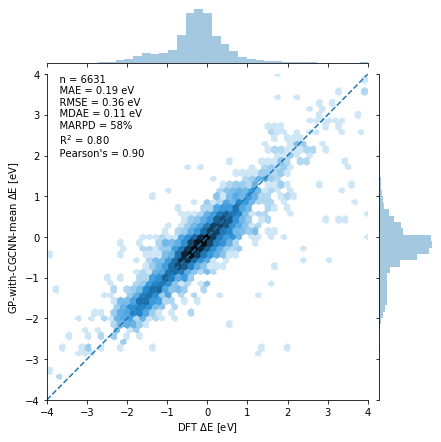

In [14]:
# Plotting results (original output space)

# Transform outputs
targets_val_gp_orig = targets_val_gp + torch.Tensor(targets_pred_val)
targets_pred_gp_orig = targets_pred_gp + torch.Tensor(targets_pred_val)
residuals = (targets_pred_gp_orig - targets_val_gp_orig).detach().numpy()

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val_gp_orig.reshape(-1),
                     targets_pred_gp_orig.reshape(-1),
                     kind='hex',
                     bins='log',
                     extent=lims*2)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val_gp_orig, targets_pred_gp_orig)
rmse = np.sqrt(mean_squared_error(targets_val_gp_orig, targets_pred_gp_orig))
mdae = median_absolute_error(targets_val_gp_orig, targets_pred_gp_orig)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred_gp_orig.detach().numpy())
                + np.abs(targets_val_gp_orig.detach().numpy().reshape(-1)))
                ).mean() * 100
r2 = r2_score(targets_val_gp_orig, targets_pred_gp_orig)
corr = np.corrcoef(targets_val_gp_orig.reshape(-1), targets_pred_gp_orig)[0, 1]

# Report
text = ('    n = %i\n' % len(targets_val_gp_orig) +
        '    MAE = %.2f eV\n' % mae + 
        '    RMSE = %.2f eV\n' % rmse + 
        '    MDAE = %.2f eV\n' % mdae + 
        '    MARPD = %i%%\n' % marpd + 
        '    R$^2$ = %.2f\n' % r2 +
        '    Pearson\'s = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

In [15]:
%load_ext ipycache

/zfsauton/home/willie/miniconda3/envs/ubench36/lib/python3.6/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/zfsauton/home/willie/miniconda3/envs/ubench36/lib/python3.6/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [16]:
%%cache calibration_val.pkl predicted_pi observed_pi

stdevs = preds.stddev.detach().numpy()

def calculate_density(percentile):
    num_within_quantile = 0
    for stdev, resid in zip(stdevs, residuals):
        norm = stats.norm(loc=0, scale=stdev)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

[Saved variables 'observed_pi, predicted_pi' to file '/zfsauton/home/willie/proj/uncertainty_benchmarking/GP_with_CGCNN_mean/Matern/calibration_val.pkl'.]



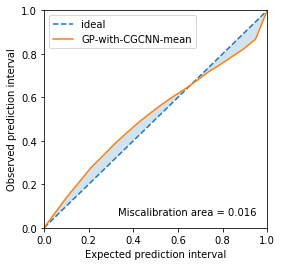

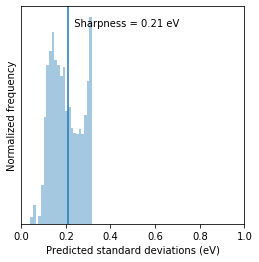

In [17]:
%matplotlib inline
from matplotlib import pyplot as plt
from shapely.geometry import Polygon


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
miscalibration_area = polygon.area

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.3f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right')

# Plot sharpness curve
xlim = [0., 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align)

In [18]:
miscalibration_area

0.01573153211788337

In [19]:
np.mean(np.abs(predicted_pi - np.array(observed_pi)))

0.04216558588448197

## Test
We never actually made the predictions during the job, so we have to make the predictions here.

##### Transformed Output Space

In [20]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Make the predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    %time preds = model(fingerprints_test)

CPU times: user 4.56 s, sys: 2.81 s, total: 7.37 s
Wall time: 7.36 s


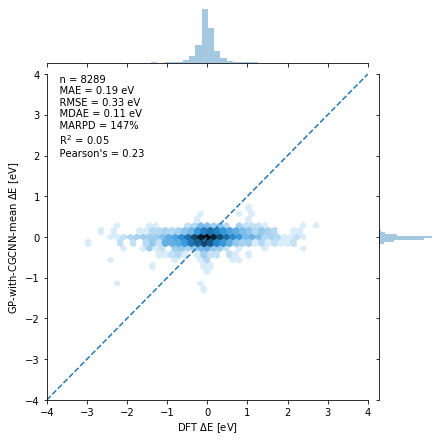

In [21]:
# Plotting results (transformed output space)

# Parse the predictions
targets_pred_gp = preds.mean
residuals = (targets_pred_gp - targets_test_gp).detach().numpy()

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_test_gp.reshape(-1),
                     targets_pred_gp.reshape(-1),
                     kind='hex',
                     bins='log',
                     extent=lims*2)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_test_gp, targets_pred_gp)
rmse = np.sqrt(mean_squared_error(targets_test_gp, targets_pred_gp))
mdae = median_absolute_error(targets_test_gp, targets_pred_gp)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred_gp.detach().numpy()) + np.abs(targets_test_gp.detach().numpy().reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_test_gp, targets_pred_gp)
corr = np.corrcoef(targets_test_gp.reshape(-1), targets_pred_gp)[0, 1]

# Report
text = ('    n = %i\n' % len(targets_test_gp) +
        '    MAE = %.2f eV\n' % mae + 
        '    RMSE = %.2f eV\n' % rmse + 
        '    MDAE = %.2f eV\n' % mdae + 
        '    MARPD = %i%%\n' % marpd + 
        '    R$^2$ = %.2f\n' % r2 +
        '    Pearson\'s = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

##### Original Output Space

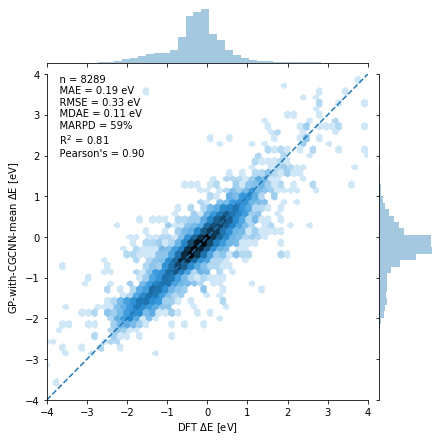

In [25]:
# Plotting results (original output space)

# Transform outputs
targets_test_gp_orig = targets_test_gp + torch.Tensor(targets_pred_test)
targets_pred_gp_orig = targets_pred_gp + torch.Tensor(targets_pred_test)
residuals = (targets_pred_gp_orig - targets_test_gp_orig).detach().numpy()

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_test_gp_orig.reshape(-1),
                     targets_pred_gp_orig.reshape(-1),
                     kind='hex',
                     bins='log',
                     extent=lims*2)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_test_gp_orig, targets_pred_gp_orig)
rmse = np.sqrt(mean_squared_error(targets_test_gp_orig, targets_pred_gp_orig))
mdae = median_absolute_error(targets_test_gp_orig, targets_pred_gp_orig)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred_gp_orig.detach().numpy())
                + np.abs(targets_test_gp_orig.detach().numpy().reshape(-1)))
                ).mean() * 100
r2 = r2_score(targets_test_gp_orig, targets_pred_gp_orig)
corr = np.corrcoef(targets_test_gp_orig.reshape(-1), targets_pred_gp_orig)[0, 1]

# Report
text = ('    n = %i\n' % len(targets_test_gp_orig) +
        '    MAE = %.2f eV\n' % mae + 
        '    RMSE = %.2f eV\n' % rmse + 
        '    MDAE = %.2f eV\n' % mdae + 
        '    MARPD = %i%%\n' % marpd + 
        '    R$^2$ = %.2f\n' % r2 +
        '    Pearson\'s = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

# Save figure
plt.savefig('parity.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [23]:
%%cache calibration_test.pkl predicted_pi observed_pi

stdevs = preds.stddev.detach().numpy()

def calculate_density(percentile):
    num_within_quantile = 0
    for stdev, resid in zip(stdevs, residuals):
        norm = stats.norm(loc=0, scale=stdev)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

[Saved variables 'observed_pi, predicted_pi' to file '/zfsauton/home/willie/proj/uncertainty_benchmarking/GP_with_CGCNN_mean/Matern/calibration_test.pkl'.]



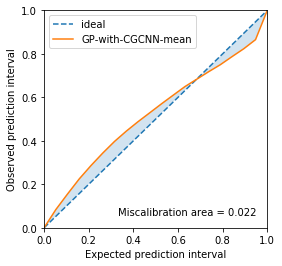

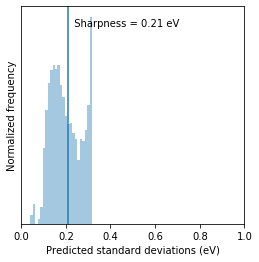

In [26]:
%matplotlib inline
from matplotlib import pyplot as plt
from shapely.geometry import Polygon


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
miscalibration_area = polygon.area

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.3f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right')

# Save
plt.savefig('calibration.pdf', dpi=300, bbox_inches='tight', transparent=True)


# Plot sharpness curve
xlim = [0., 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align)

# Save
plt.savefig('sharpness.pdf', dpi=300, bbox_inches='tight', transparent=True)

## Results-by-adsorbate
Let's dig into details and see how our results turned out for each adsorbate. Note that this section shows the results from a single model trained on a pooled dataset. Only the performance metrics are partitioned by adsorbate.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np


class SeabornFig2Grid():
    '''
    Credit goes to ImportanceOfBeingErnest on StackOverflow
    https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
    '''

    def __init__(self, seaborngrid, fig, subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [ ]:
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

# Prepare figure for all adsorbates
fig = plt.figure(figsize=(20, 4))
gs = gridspec.GridSpec(1, len(adsorbates))

# Parse out the data for each adsorbate
for i, ads in enumerate(adsorbates):
    _targets_val = []
    _targets_pred = []
    for doc, target, pred in zip(docs_val, targets_val_gp_orig, targets_pred_gp_orig):
        if doc['adsorbate'] == ads:
            _targets_val.append(target)
            _targets_pred.append(pred)
    _targets_val = np.array(_targets_val).reshape(-1)
    _targets_pred = np.array(_targets_pred).reshape(-1)

    # Plot accuracy
    lims = [-5, 5]
    grid = sns.jointplot(_targets_val, _targets_pred,
                         kind='hex',
                         bins='log',
                         extent=lims*2)
    ax = grid.ax_joint
    _ = ax.set_xlim(lims)
    _ = ax.set_ylim(lims)
    _ = ax.plot(lims, lims, '--')
    _ = ax.set_xlabel('DFT $\Delta$E [eV]')
    _ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)
    _ = ax.set_title(ads)

    # Calculate + report metrics
    mae = mean_absolute_error(_targets_val, _targets_pred)
    rmse = np.sqrt(mean_squared_error(_targets_val, _targets_pred))
    r2 = r2_score(_targets_val, _targets_pred)
    grid.ax_marg_x.text(x=lims[0], y=0,
                        verticalalignment='bottom',
                        s='%s\n' % ads)
    text = ('  n = %i\n'
            '  MAE = %.2f eV\n'
            '  RMSE = %.2f eV\n'
            '  R$^2$ = %.2f'
            % (len(_targets_val), mae, rmse, r2))
    ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

    # Put the figure into the subplot
    sfg = SeabornFig2Grid(grid, fig, gs[i])
gs.tight_layout(fig)